---
title: A Simple Image De-blurring Example
description: Fun with BCCB matrices.
date: 7/5/2022
draft: false
bibliography: references.bib
csl: annals_statistics.csl
format:
  html:
    code-fold: true
---

The goal of this post is to write some code for solving a simple image de-blurring problem.

# Problem Setup

We will start by converting the following 3024 x 4032 pixel image of the Grand Canyon

![](grand_canyon.jpg)

to grayscale to get 

![](grayscale_grand_canyon.jpg)

and then apply a Gaussian blur to get

![](blurred_grand_canyon.jpg)

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageOps

# Load image
img = Image.open("grand_canyon.jpg")
img = ImageOps.grayscale(img)
img = np.asarray(img)
img = img/255
M, N = img.shape

im = Image.fromarray(255*img)
im = im.convert('RGB')
im.save("grayscale_grand_canyon.jpg")

# Define blur operator using sigma
blur_sigma = 20.0
blur_op = lambda x: gaussian_filter(x, blur_sigma, mode='wrap')

# Apply blur and save
blurred_img = blur_op(img)
im = Image.fromarray(255*blurred_img)
im = im.convert('RGB')
im.save("blurred_grand_canyon.jpg")

# BCCB Blurring

Let's describe what we just did. We began with an initial image $x$, and then applied a Gaussian blurring operator $A$ to obtain the observation
$$
y = A x.
$$
Note that the blurring is a linear operator and thus can be represented by a matrix $A$, even though we never actually form the matrix $A$. Note that we have also used the `mode = 'wrap'` option, which specifies a periodic boundary condition for the blurring. We choose this because this choice makes $A$ a block circulant with circulant blocks (BCCB) matrix, which have several nice properties (see [@Hansen2008] for a nice overview of structured matrices and image de-blurring). One such property is that we can diagonalize the matrix $A$ via the two-dimensional discrete Fourier transform, i.e., 
$$
A = F^H  \Lambda  F
$$
where $\Lambda$ is a diagonal matrix. This makes solving systems involving $A$ fairly straightforward and cheap to do.

If we want to de-blur the image $y$, one thing we might try is to do
$$
x = A^{-1}  y.
$$
From our diagonalization and the fact that $F^{-1} = F^H$, we can compute this as
$$
\begin{align*}
x &= \left( F^H  \Lambda F \right)^{-1} y \\
&= F^H  \Lambda^{-1}  F y.
\end{align*}
$$
But what is $\Lambda^{-1}$? We can compute this by picking a random vector $v$, and doing elementwise division between $v$ and $F A F^H v$. Let's do this, and then use the result to compute $x = A^{-1} y$.

<!-- 
 If we want to obtain the de-blurred image $\bm x$, we might try to compute
$$
\bm x = \bm A^{-1} \bm y.
$$ -->

In [2]:
# Draw a random image
rand_img = np.random.randn(M,N)
mat_prod_rand_img = np.fft.fft2(blur_op(np.fft.ifft2(rand_img, norm='ortho')), norm='ortho')
lam = mat_prod_rand_img/rand_img
lam = np.real(lam) # We know it should be real
lam_inv = 1/lam

# Now use to invert, and save result
x_approx = np.fft.ifft2(lam_inv*np.fft.fft2(blurred_img, norm='ortho'), norm='ortho')
x_approx = np.real(x_approx)

im = Image.fromarray(255*x_approx)
im = im.convert('RGB')
im.save("deblurred_grand_canyon_direct_inversion.jpg")

![](deblurred_grand_canyon_direct_inversion.jpg)

So that actually worked out pretty well. In reality, our image would likely be contaminated by at least some small amount of noise. Let's see what happens if we apply our same inversion procedure to
$$
\begin{align*}
y &= A x + \varepsilon, \\
\varepsilon &\sim \mathcal{N}\left(0, \sigma^2 I \right)
\end{align*}
$$
with a comically small noise standard deviation of $\sigma = 0.000000001$. Our new observation is

![](noisy_blurred_grand_canyon.jpg)

which is visually indistinguishable from our previous one with no noise added to the blurred image. However, if we compute $x = A^{-1} y$ in this case we obtain

![](noisy_deblurred_grand_canyon_direct_inversion.jpg)

which is nonsense.


In [3]:
noise_sigma = 0.000000001

# Add a little bit of noise and save
np.random.seed(0) # Set seed
noisy_blurred_img = blur_op(img) + noise_sigma*np.random.randn(M,N) 

im = Image.fromarray(255*noisy_blurred_img)
im = im.convert('RGB')
im.save("noisy_blurred_grand_canyon.jpg")

# Now invert using the same method as before and save result
x_approx = np.fft.ifft2(lam_inv*np.fft.fft2(noisy_blurred_img, norm='ortho'), norm='ortho')
x_approx = np.real(x_approx)

im = Image.fromarray(255*x_approx)
im = im.convert('RGB')
im.save("noisy_deblurred_grand_canyon_direct_inversion.jpg")

The reason this happens is because although our blurring operator $A$ is invertible, it is extremely ill-conditioned and thus will yield unexpected results such as this. Note that the diagonal entries of $\Lambda$ are in fact the eigenvalues of $A$, so examining these in @fig-blur_mat_eigvals can give us a sense of why the matrix is ill-conditioned.

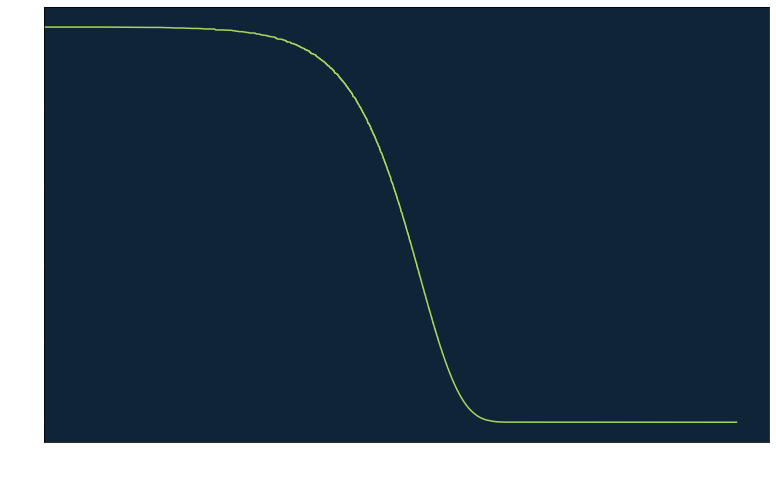

In [4]:
#| label: fig-blur_mat_eigvals
#| fig-cap: The eigenvalues of $A$ in descending order.

import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = '#0F2537'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Compute eigvalues in descending order
eigvals = np.flip(np.asarray(sorted(lam.flatten())))

# Plot
plt.figure(figsize=(13,8))
plt.semilogx(eigvals, color='#A5D75E')
plt.xlabel("nth eigenvalue")
plt.ylabel("eigenvalue")
plt.show()

The condition number of $A$ is equal to the ratio of the largest and smallest eigenvalues. The fact that the smallest eigenvalue is near zero and the largest is near one gives $A$ a very large condition number and thus $A$ is very ill-conditioned. In other words, recovering $x$ from $y$ in this manner is a very ill-posed problem.

# Regularized Inversion

In the case that our blurred image contains any amount of noise, we clearly cannot settle for simply computing $x = A^{-1} y$. One way to tackle this problem is to instead look for the solution of
$$
x^\star = \text{argmin}_x \,\, \| A x - y \|_2^2 + \mathcal{R}(x)
$$ {#eq-regularized_sol}
for some regularization term $\mathcal{R}(x)$. Ignoring $\mathcal{R}(x)$, note that if we found an $x$ such that $A x = y$ then the objective would be equal to zero and $x = x^\star$. However, we have already seen that this solution would do us no good. This explains the role of $\mathcal{R}(x)$: to make the problem less ill-posed, i.e. well-posed. For now we will consider the choice
$$
\mathcal{R}(x) = \gamma \| L x \|_2^2 = \gamma x^T L^T L x.
$$
where $L$ encodes a discrete negative-Laplacian operator. This regularization term promotes smooth solutions for the reconstructed image $x$, and the degree of this smoothness is controlled by the parameter $\gamma > 0$. For convenience, we will define the discrete gradient $L$ to use periodic boundary conditions which will make $L^T L$ a BCCB matrix that can be diagonalized by the discrete Fourier transform as
$$
L^T L = F^H \Pi F
$$
for some diagonal matrix $\Pi$.

Note that with this choice of $\mathcal{R}(x)$, if we set the gradient of the objective function in (@eq-regularized_sol) equal to zero we obtain the equation
$$
2 A^T(Ax - y) + 2 \gamma L^T L x = 0
$$
for the minimizer, which is solved by
$$
x = \left( A^T A + \gamma L^T L \right)^{-1} A^T y
$$
This is where our choice of BCCB matrices throughout will pay off. While it looks like we will need to solve a sparse linear system, we can actually compute the solution using only FFTs and elementwise operations thanks for our diagonalization. Inserting $A = F^H \Lambda F$ and $L = F^H \Pi F$, we have
$$
\begin{align*}
x &= \left( A^T A + \gamma L^T L \right)^{-1} A^T y \\
&= \left( F^H \Lambda F F^H \Lambda F + \gamma F^H \Pi F  \right)^{-1} F^H \Lambda F y \\
&= \left( F^H \Lambda^2 F + \gamma F^H \Pi F \right)^{-1} F^H \Lambda F y \\
&= \left( F^H \left( \Lambda^2 + \gamma \Pi  \right) F \right)^{-1} F^H \Lambda F y \\
&= F^H \left( \Lambda^2 + \gamma \Pi  \right)^{-1} F F^H \Lambda F y \\
&= F^H \left( \Lambda^2 + \gamma \Pi  \right)^{-1} \Lambda F y.
\end{align*}
$$
Note that the only matrix inverse remaining is that of a diagonal matrix, so we can easily compute the solution. Let's try this out.

In [18]:
%%capture

import scipy.sparse as sp

# First we need to construct our L matrix

# Construct our L matrix
d_mat_vert = sp.eye(N)
d_mat_vert.setdiag(-1,k=-1)
d_mat_vert = sp.csc_matrix(d_mat_vert)
d_mat_vert[0,-1] = -1 # For periodic BCs
eye_horiz = sp.eye(M)
d_mat_one = sp.kron(eye_horiz, d_mat_vert)

d_mat_horiz = sp.eye(M)
d_mat_horiz.setdiag(-1,k=-1)
d_mat_horiz = sp.csc_matrix(d_mat_horiz)
d_mat_horiz[0,-1] = -1 # For periodic BCs
eye_vert = sp.eye(N)
d_mat_two = sp.kron(d_mat_horiz, eye_vert)

d_mat = sp.vstack([d_mat_one, d_mat_two])
L_mat = d_mat.T @ d_mat

# Next, we need to compute $\Pi$ like we did earlier with $\Lambda$.
rand_img = np.random.randn(M,N)
mat_prod_rand_img = np.fft.fft2( (L_mat @ np.fft.ifft2(rand_img, norm='ortho').flatten() ).reshape((M,N)), norm='ortho')
pi = mat_prod_rand_img/rand_img
pi = np.real(pi) # We know it should be real
pi_inv = 1/pi

# Now compute the regularized solution
gamma = 0.00005*(1/M)

soln = np.fft.fft2(noisy_blurred_img, norm='ortho')
soln *= lam
soln *= 1/( (lam**2) + (gamma*(pi*2)) )
soln = np.fft.ifft2(soln, norm='ortho')
soln = np.real(soln)

# Save the solution
im = Image.fromarray(255*soln)
im = im.convert('RGB')
im.save("regularized_deblurred_grand_canyon.jpg")

![](regularized_deblurred_grand_canyon.jpg)

This is much better than what we got by instead computing $x = A^{-1} y$. Note that I didn't talk about how to pick $\gamma$, which in this case I tuned by hand. 

In the next post, we'll use [`CuPy`](https://cupy.dev/) to approach this same problem but with a different form of the regularizer $\mathcal{R}(x)$.